Esteban Castañeda Blanco C01795

Israel López Vallecillo C04396

Daniel Lizano Morales C04285

In [33]:
import os
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from efficientnet_pytorch import EfficientNet
import torch.nn as nn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
data_transforms = {
    'all': transforms.Compose([
        transforms.Resize((224, 224)),  
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ]),
}


In [74]:
base_dir = os.path.join('Plant_leave_diseases_dataset', 'original')

In [75]:
full_dataset = datasets.ImageFolder(base_dir, transform=data_transforms['all'])

In [114]:
indices = list(range(len(full_dataset)))

# Get the directory paths of images
image_paths = [sample[0] for sample in full_dataset.samples]

labels = [os.path.split(os.path.dirname(path))[-1] for path in image_paths]

In [115]:
#Obtenemos el 20% de los datos 
train_val_indices, _ = train_test_split(indices, test_size=0.8, stratify=labels, random_state=42)

#Obtenemos las etiquetas de los datos de entrenamiento
train_val_labels = [labels[i] for i in train_val_indices]

#dividir el 20% en 10% de entrenamiento y 10% de validación
train_indices, val_indices = train_test_split(train_val_indices, test_size=0.5, stratify=train_val_labels, random_state=42)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

In [116]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

print(f"Número de imágenes en el conjunto de entrenamiento: {len(train_loader.dataset)}")
print(f"Número de imágenes en el conjunto de validación: {len(val_loader.dataset)}")

Número de imágenes en el conjunto de entrenamiento: 6148
Número de imágenes en el conjunto de validación: 6149


In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.efficientnet_b2()

# Modify the first convolutional layer to accept a different number of input channels (e.g., 1 instead of 3)
new_in_channels = 1  # Change this to the desired number of input channels
original_conv1 = model.features[0][0]

new_conv1 = nn.Conv2d(
    in_channels=new_in_channels,
    out_channels=original_conv1.out_channels,
    kernel_size=original_conv1.kernel_size,
    stride=original_conv1.stride,
    padding=original_conv1.padding,
    bias=original_conv1.bias
)

# Initialize the weights of the new conv layer
with torch.no_grad():
    if new_in_channels == 1:
        # Average the weights of the original conv layer across the input channels
        new_conv1.weight = nn.Parameter(original_conv1.weight.mean(dim=1, keepdim=True))
    else:
        # Initialize weights by repeating the mean weights or use a different strategy
        new_conv1.weight[:, :3] = original_conv1.weight
        if new_in_channels > 3:
            for i in range(3, new_in_channels):
                new_conv1.weight[:, i:i+1] = original_conv1.weight.mean(dim=1, keepdim=True)

# Replace the first convolutional layer in the model
model.features[0][0] = new_conv1

# Print the modified first convolutional layer
print("Modified first conv layer:", model.features[0][0])
# model._conv_stem = nn.Conv2d(1, model._conv_stem.out_channels, kernel_size=model._conv_stem.kernel_size, stride=model._conv_stem.stride, padding=model._conv_stem.padding, bias=False)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Modified first conv layer: Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)


In [102]:
def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    return figure

In [104]:
def train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=10, patience=3):
    best_val_loss = float('inf')
    epochs_no_improve = 0
    model_save_path = 'best_model.pth'
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in tqdm(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_loss = running_loss / len(train_loader)
        train_acc = correct / total
        
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_loss = val_loss / len(val_loader)
        val_acc = correct / total
        
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}')
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), model_save_path)
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered!")
            break
    
    return model

In [105]:
def evaluate_model(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    accuracy = correct / total
    cm = confusion_matrix(all_labels, all_preds)
    cm_figure = plot_confusion_matrix(cm, class_names=dataloader.dataset.dataset.classes)
    
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, fmt='g', xticklabels=dataloader.dataset.dataset.classes, yticklabels=dataloader.dataset.dataset.classes)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix - Evaluation')
    plt.show()
    print(f'Accuracy: {accuracy:.4f}')
    print(classification_report(all_labels, all_preds, target_names=dataloader.dataset.dataset.classes))
    
    return accuracy

In [118]:
trained_model = train_model(model, criterion, optimizer, train_loader, val_loader, device, num_epochs=20, patience=3)


100%|██████████| 193/193 [01:20<00:00,  2.41it/s]


Epoch 1/1
Train Loss: 3.2523 Acc: 0.1905
Val Loss: 2.7881 Acc: 0.2737


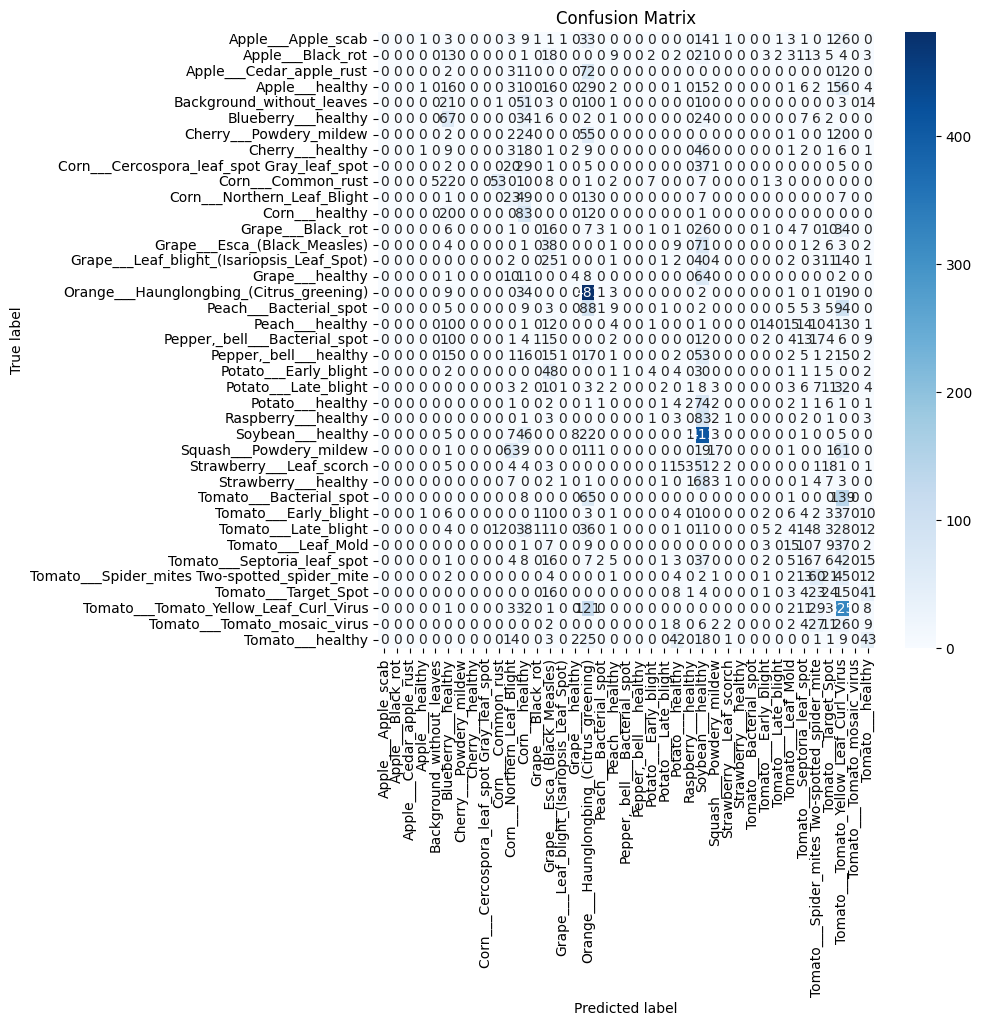

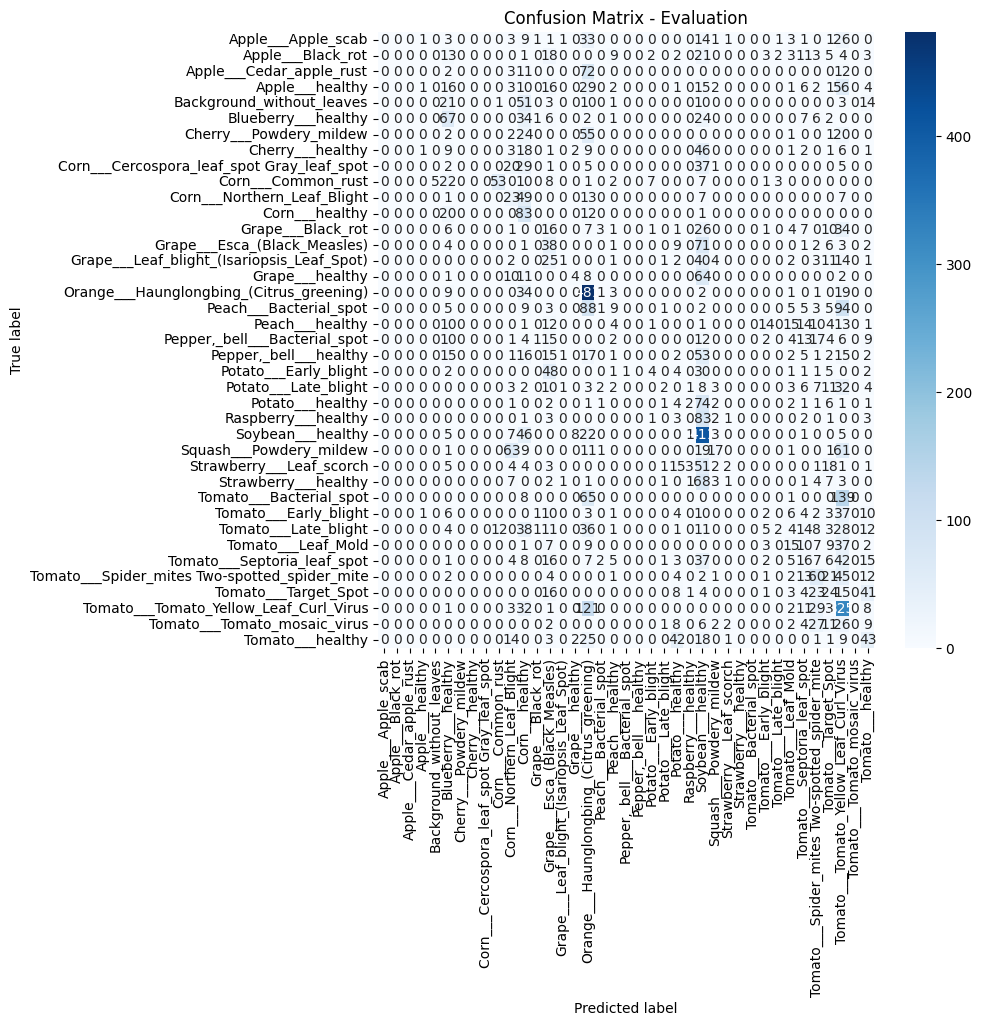

Accuracy: 0.2737
                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.00      0.00      0.00       100
                            Apple___Black_rot       0.00      0.00      0.00       100
                     Apple___Cedar_apple_rust       0.00      0.00      0.00       100
                              Apple___healthy       0.25      0.01      0.01       165
                    Background_without_leaves       0.00      0.00      0.00       114
                          Blueberry___healthy       0.25      0.45      0.32       150
                      Cherry___Powdery_mildew       0.00      0.00      0.00       105
                             Cherry___healthy       0.00      0.00      0.00       100
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       100
                           Corn___Common_rust       0.80      0.45      0.57       119
                  Corn___

c:\Users\ISRAEL\Documents\Estudios\UCR\Computacion\MachineLearning\proyecto3\plant_disease_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ISRAEL\Documents\Estudios\UCR\Computacion\MachineLearning\proyecto3\plant_disease_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\ISRAEL\Documents\Estudios\UCR\Computacion\MachineLearning\proyecto3\plant_disease_classification\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetric

0.2737030411449016

In [119]:
evaluate_model(trained_model, val_loader, device)